In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline
#A100 80GB

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility # model
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    model = ACANet_PNA(**pub_args, deg=deg).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [6]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            'aggregators': ['mean', 'min', 'max', 'sum','std'],
            'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [7]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [8]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 11.3178 tsm_loss: 4.7459 reg_loss: 6.5719 n_pos_triplets: 212814;  Val: 6.9114 Test: 6.9319
Epoch: 002, Loss: 7.7582 tsm_loss: 1.9911 reg_loss: 5.7671 n_pos_triplets: 210216;  Val: 6.9081 Test: 6.9287
Epoch: 003, Loss: 6.4469 tsm_loss: 1.6454 reg_loss: 4.8015 n_pos_triplets: 202630;  Val: 6.8972 Test: 6.9178
Epoch: 004, Loss: 4.9044 tsm_loss: 1.4478 reg_loss: 3.4565 n_pos_triplets: 199444;  Val: 6.8606 Test: 6.8815
Epoch: 005, Loss: 3.0792 tsm_loss: 1.4479 reg_loss: 1.6313 n_pos_triplets: 184280;  Val: 6.6357 Test: 6.6589
Epoch: 006, Loss: 2.3355 tsm_loss: 1.4325 reg_loss: 0.9029 n_pos_triplets: 169758;  Val: 5.9131 Test: 5.9379
Epoch: 007, Loss: 2.0964 tsm_loss: 1.2648 reg_loss: 0.8317 n_pos_triplets: 183505;  Val: 4.9199 Test: 4.9440
Epoch: 008, Loss: 1.8860 tsm_loss: 1.1692 reg_loss: 0.7168 n_pos_triplets: 168805;  Val: 3.7357 Test: 3.7530
Epoch: 009, Loss: 1.8369 tsm_loss: 1.1500 reg_loss: 0.6869 n_pos_triplets: 176386;  Val: 2.6448 Test: 2.6506
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.1629 tsm_loss: 14.5194 reg_loss: 6.1629 n_pos_triplets: 221002;  Val: 6.8468 Test: 6.8674
Epoch: 002, Loss: 4.7616 tsm_loss: 18.9192 reg_loss: 4.7616 n_pos_triplets: 213818;  Val: 6.8426 Test: 6.8632
Epoch: 003, Loss: 3.2595 tsm_loss: 18.8471 reg_loss: 3.2595 n_pos_triplets: 211347;  Val: 6.8388 Test: 6.8594
Epoch: 004, Loss: 1.4723 tsm_loss: 15.7923 reg_loss: 1.4723 n_pos_triplets: 206298;  Val: 6.8350 Test: 6.8557
Epoch: 005, Loss: 1.0178 tsm_loss: 11.1026 reg_loss: 1.0178 n_pos_triplets: 193904;  Val: 6.6306 Test: 6.6501
Epoch: 006, Loss: 0.7598 tsm_loss: 8.2318 reg_loss: 0.7598 n_pos_triplets: 188224;  Val: 5.6392 Test: 5.6525
Epoch: 007, Loss: 0.7070 tsm_loss: 7.0557 reg_loss: 0.7070 n_pos_triplets: 178423;  Val: 4.6482 Test: 4.6611
Epoch: 008, Loss: 0.6511 tsm_loss: 6.7718 reg_loss: 0.6511 n_pos_triplets: 172945;  Val: 3.9580 Test: 3.9693
Epoch: 009, Loss: 0.6161 tsm_loss: 6.3690 reg_loss: 0.6161 n_pos_triplets: 176312;  Val: 3.2661 Test: 3.2741
Epoch: 010, Lo

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.8507 tsm_loss: 5.2994 reg_loss: 6.5512 n_pos_triplets: 214777;  Val: 6.9137 Test: 6.9380
Epoch: 002, Loss: 8.0406 tsm_loss: 2.0690 reg_loss: 5.9715 n_pos_triplets: 204140;  Val: 6.9103 Test: 6.9347
Epoch: 003, Loss: 6.8624 tsm_loss: 1.5848 reg_loss: 5.2776 n_pos_triplets: 200018;  Val: 6.8995 Test: 6.9242
Epoch: 004, Loss: 5.7032 tsm_loss: 1.3548 reg_loss: 4.3484 n_pos_triplets: 181214;  Val: 6.8554 Test: 6.8811
Epoch: 005, Loss: 4.3604 tsm_loss: 1.3525 reg_loss: 3.0079 n_pos_triplets: 184099;  Val: 6.6508 Test: 6.6763
Epoch: 006, Loss: 2.5575 tsm_loss: 1.2836 reg_loss: 1.2739 n_pos_triplets: 165762;  Val: 6.1096 Test: 6.1308
Epoch: 007, Loss: 2.2125 tsm_loss: 1.2690 reg_loss: 0.9435 n_pos_triplets: 158633;  Val: 4.9990 Test: 5.0102
Epoch: 008, Loss: 1.9659 tsm_loss: 1.1088 reg_loss: 0.8571 n_pos_triplets: 177952;  Val: 3.7753 Test: 3.7769
Epoch: 009, Loss: 1.7506 tsm_loss: 1.0262 reg_loss: 0.7243 n_pos_triplets: 159094;  Val: 2.6850 Test: 2.6708
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.1846 tsm_loss: 10.9468 reg_loss: 6.1846 n_pos_triplets: 207353;  Val: 6.8949 Test: 6.9191
Epoch: 002, Loss: 4.9606 tsm_loss: 12.8708 reg_loss: 4.9606 n_pos_triplets: 200005;  Val: 6.8902 Test: 6.9144
Epoch: 003, Loss: 3.5380 tsm_loss: 12.5032 reg_loss: 3.5380 n_pos_triplets: 197978;  Val: 6.8841 Test: 6.9084
Epoch: 004, Loss: 1.9069 tsm_loss: 11.0824 reg_loss: 1.9069 n_pos_triplets: 196608;  Val: 6.8657 Test: 6.8901
Epoch: 005, Loss: 0.9374 tsm_loss: 8.4520 reg_loss: 0.9374 n_pos_triplets: 191955;  Val: 6.6469 Test: 6.6588
Epoch: 006, Loss: 0.8204 tsm_loss: 7.2110 reg_loss: 0.8204 n_pos_triplets: 193886;  Val: 5.2263 Test: 5.2126
Epoch: 007, Loss: 0.7315 tsm_loss: 5.6842 reg_loss: 0.7315 n_pos_triplets: 187705;  Val: 4.0652 Test: 4.0372
Epoch: 008, Loss: 0.7080 tsm_loss: 6.2929 reg_loss: 0.7080 n_pos_triplets: 182723;  Val: 3.4170 Test: 3.3805
Epoch: 009, Loss: 0.6619 tsm_loss: 5.9829 reg_loss: 0.6619 n_pos_triplets: 177148;  Val: 2.1330 Test: 2.0877
Epoch: 010, Los

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.0310 tsm_loss: 4.4073 reg_loss: 6.6237 n_pos_triplets: 213032;  Val: 6.8821 Test: 6.9171
Epoch: 002, Loss: 7.8747 tsm_loss: 1.9481 reg_loss: 5.9266 n_pos_triplets: 200098;  Val: 6.8807 Test: 6.9158
Epoch: 003, Loss: 6.5782 tsm_loss: 1.5324 reg_loss: 5.0458 n_pos_triplets: 191203;  Val: 6.8712 Test: 6.9063
Epoch: 004, Loss: 5.1152 tsm_loss: 1.3296 reg_loss: 3.7856 n_pos_triplets: 169972;  Val: 6.8240 Test: 6.8599
Epoch: 005, Loss: 3.2254 tsm_loss: 1.2739 reg_loss: 1.9516 n_pos_triplets: 159890;  Val: 6.6150 Test: 6.6526
Epoch: 006, Loss: 2.0419 tsm_loss: 1.2408 reg_loss: 0.8010 n_pos_triplets: 153340;  Val: 5.9756 Test: 6.0138
Epoch: 007, Loss: 1.8671 tsm_loss: 1.0677 reg_loss: 0.7994 n_pos_triplets: 146239;  Val: 5.0888 Test: 5.1274
Epoch: 008, Loss: 1.6482 tsm_loss: 0.9726 reg_loss: 0.6756 n_pos_triplets: 143462;  Val: 4.0612 Test: 4.0988
Epoch: 009, Loss: 1.5488 tsm_loss: 0.9480 reg_loss: 0.6008 n_pos_triplets: 142611;  Val: 2.8082 Test: 2.8419
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.1277 tsm_loss: 12.3287 reg_loss: 6.1277 n_pos_triplets: 214833;  Val: 6.5801 Test: 6.6150
Epoch: 002, Loss: 4.9779 tsm_loss: 16.1362 reg_loss: 4.9779 n_pos_triplets: 215627;  Val: 6.5816 Test: 6.6165
Epoch: 003, Loss: 3.6284 tsm_loss: 16.9109 reg_loss: 3.6284 n_pos_triplets: 212966;  Val: 6.5830 Test: 6.6179
Epoch: 004, Loss: 1.9292 tsm_loss: 14.2922 reg_loss: 1.9292 n_pos_triplets: 206918;  Val: 6.5822 Test: 6.6172
Epoch: 005, Loss: 0.8340 tsm_loss: 9.3329 reg_loss: 0.8340 n_pos_triplets: 193361;  Val: 6.4825 Test: 6.5151
Epoch: 006, Loss: 0.7246 tsm_loss: 7.1590 reg_loss: 0.7246 n_pos_triplets: 180761;  Val: 5.6405 Test: 5.6640
Epoch: 007, Loss: 0.6445 tsm_loss: 6.2072 reg_loss: 0.6445 n_pos_triplets: 179980;  Val: 4.6293 Test: 4.6414
Epoch: 008, Loss: 0.6101 tsm_loss: 5.1988 reg_loss: 0.6101 n_pos_triplets: 172791;  Val: 3.8030 Test: 3.8095
Epoch: 009, Loss: 0.5901 tsm_loss: 5.2692 reg_loss: 0.5901 n_pos_triplets: 165818;  Val: 2.6780 Test: 2.6846
Epoch: 010, Los

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.4780 tsm_loss: 5.0851 reg_loss: 6.3929 n_pos_triplets: 215219;  Val: 6.6612 Test: 6.7007
Epoch: 002, Loss: 7.9247 tsm_loss: 1.8971 reg_loss: 6.0277 n_pos_triplets: 197831;  Val: 6.6567 Test: 6.6962
Epoch: 003, Loss: 7.0492 tsm_loss: 1.5205 reg_loss: 5.5287 n_pos_triplets: 193946;  Val: 6.6487 Test: 6.6881
Epoch: 004, Loss: 6.1371 tsm_loss: 1.3006 reg_loss: 4.8365 n_pos_triplets: 192606;  Val: 6.6171 Test: 6.6563
Epoch: 005, Loss: 5.0566 tsm_loss: 1.2138 reg_loss: 3.8428 n_pos_triplets: 182446;  Val: 6.4829 Test: 6.5220
Epoch: 006, Loss: 3.5137 tsm_loss: 1.1698 reg_loss: 2.3439 n_pos_triplets: 166150;  Val: 6.0630 Test: 6.1054
Epoch: 007, Loss: 2.0760 tsm_loss: 1.1862 reg_loss: 0.8898 n_pos_triplets: 156890;  Val: 5.1997 Test: 5.2509
Epoch: 008, Loss: 2.1382 tsm_loss: 1.1089 reg_loss: 1.0294 n_pos_triplets: 150863;  Val: 4.1997 Test: 4.2542
Epoch: 009, Loss: 1.7348 tsm_loss: 0.9996 reg_loss: 0.7352 n_pos_triplets: 151856;  Val: 3.4060 Test: 3.4668
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4226 tsm_loss: 9.3524 reg_loss: 6.4226 n_pos_triplets: 219463;  Val: 6.7132 Test: 6.7527
Epoch: 002, Loss: 5.6695 tsm_loss: 12.9706 reg_loss: 5.6695 n_pos_triplets: 214247;  Val: 6.7095 Test: 6.7490
Epoch: 003, Loss: 4.8183 tsm_loss: 13.7684 reg_loss: 4.8183 n_pos_triplets: 211665;  Val: 6.7027 Test: 6.7421
Epoch: 004, Loss: 3.7283 tsm_loss: 13.6879 reg_loss: 3.7283 n_pos_triplets: 210896;  Val: 6.6962 Test: 6.7355
Epoch: 005, Loss: 2.2288 tsm_loss: 12.1155 reg_loss: 2.2288 n_pos_triplets: 209453;  Val: 6.6834 Test: 6.7223
Epoch: 006, Loss: 0.9163 tsm_loss: 7.1532 reg_loss: 0.9163 n_pos_triplets: 194537;  Val: 6.4744 Test: 6.5153
Epoch: 007, Loss: 0.7437 tsm_loss: 6.0856 reg_loss: 0.7437 n_pos_triplets: 189843;  Val: 5.2741 Test: 5.3113
Epoch: 008, Loss: 0.6518 tsm_loss: 5.5438 reg_loss: 0.6518 n_pos_triplets: 184669;  Val: 3.9426 Test: 3.9941
Epoch: 009, Loss: 0.6124 tsm_loss: 5.2324 reg_loss: 0.6124 n_pos_triplets: 175221;  Val: 2.7608 Test: 2.8020
Epoch: 010, Los

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.3433 tsm_loss: 4.9219 reg_loss: 6.4214 n_pos_triplets: 220472;  Val: 6.6805 Test: 6.6263
Epoch: 002, Loss: 7.9051 tsm_loss: 1.9952 reg_loss: 5.9099 n_pos_triplets: 201889;  Val: 6.6750 Test: 6.6209
Epoch: 003, Loss: 6.7361 tsm_loss: 1.5460 reg_loss: 5.1901 n_pos_triplets: 199895;  Val: 6.6571 Test: 6.6034
Epoch: 004, Loss: 5.5654 tsm_loss: 1.4209 reg_loss: 4.1445 n_pos_triplets: 188784;  Val: 6.5889 Test: 6.5366
Epoch: 005, Loss: 3.9948 tsm_loss: 1.3494 reg_loss: 2.6454 n_pos_triplets: 188051;  Val: 6.3695 Test: 6.3202
Epoch: 006, Loss: 2.4060 tsm_loss: 1.4118 reg_loss: 0.9941 n_pos_triplets: 167298;  Val: 5.7678 Test: 5.7261
Epoch: 007, Loss: 2.2430 tsm_loss: 1.2772 reg_loss: 0.9658 n_pos_triplets: 174389;  Val: 4.7274 Test: 4.6971
Epoch: 008, Loss: 1.8616 tsm_loss: 1.1171 reg_loss: 0.7445 n_pos_triplets: 172201;  Val: 3.7161 Test: 3.6964
Epoch: 009, Loss: 1.7437 tsm_loss: 1.0120 reg_loss: 0.7317 n_pos_triplets: 163805;  Val: 2.7413 Test: 2.7393
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 5.8769 tsm_loss: 11.4146 reg_loss: 5.8769 n_pos_triplets: 209366;  Val: 6.7137 Test: 6.6593
Epoch: 002, Loss: 4.2792 tsm_loss: 13.4127 reg_loss: 4.2792 n_pos_triplets: 203917;  Val: 6.7069 Test: 6.6526
Epoch: 003, Loss: 2.4291 tsm_loss: 11.5802 reg_loss: 2.4291 n_pos_triplets: 203293;  Val: 6.6989 Test: 6.6446
Epoch: 004, Loss: 0.9393 tsm_loss: 7.0862 reg_loss: 0.9393 n_pos_triplets: 189935;  Val: 6.6847 Test: 6.6306
Epoch: 005, Loss: 0.7716 tsm_loss: 6.4795 reg_loss: 0.7716 n_pos_triplets: 188317;  Val: 6.4259 Test: 6.3713
Epoch: 006, Loss: 0.7307 tsm_loss: 5.8827 reg_loss: 0.7307 n_pos_triplets: 183449;  Val: 5.5418 Test: 5.4921
Epoch: 007, Loss: 0.6958 tsm_loss: 5.6688 reg_loss: 0.6958 n_pos_triplets: 177487;  Val: 4.5176 Test: 4.4791
Epoch: 008, Loss: 0.6577 tsm_loss: 5.4042 reg_loss: 0.6577 n_pos_triplets: 173001;  Val: 3.6947 Test: 3.6630
Epoch: 009, Loss: 0.6481 tsm_loss: 6.1524 reg_loss: 0.6481 n_pos_triplets: 177629;  Val: 2.6425 Test: 2.6264
Epoch: 010, Loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 390, Loss: 0.1360 tsm_loss: 0.0268 reg_loss: 0.1091 n_pos_triplets: 13571;  Val: 0.6270 Test: 0.6676
Epoch: 391, Loss: 0.1682 tsm_loss: 0.0317 reg_loss: 0.1365 n_pos_triplets: 15577;  Val: 0.6127 Test: 0.6600
Epoch: 392, Loss: 0.1207 tsm_loss: 0.0285 reg_loss: 0.0922 n_pos_triplets: 14572;  Val: 0.6165 Test: 0.6724
Epoch: 393, Loss: 0.1692 tsm_loss: 0.0276 reg_loss: 0.1416 n_pos_triplets: 14824;  Val: 0.6086 Test: 0.6652
Epoch: 394, Loss: 0.1274 tsm_loss: 0.0283 reg_loss: 0.0991 n_pos_triplets: 14028;  Val: 0.6106 Test: 0.6592
Epoch: 395, Loss: 0.1309 tsm_loss: 0.0285 reg_loss: 0.1024 n_pos_triplets: 14678;  Val: 0.6112 Test: 0.6552
Epoch: 396, Loss: 0.1303 tsm_loss: 0.0298 reg_loss: 0.1005 n_pos_triplets: 14867;  Val: 0.6031 Test: 0.6761
Epoch: 397, Loss: 0.1327 tsm_loss: 0.0279 reg_loss: 0.1048 n_pos_triplets: 14882;  Val: 0.6088 Test: 0.6514
Epoch: 398, Loss: 0.1174 tsm_loss: 0.0271 reg_loss: 0.0903 n_pos_triplets: 14703;  Val: 0.6016 Test: 0.6491
Epoch: 399, Loss: 0.1334 tsm

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4032 tsm_loss: 16.6167 reg_loss: 6.4032 n_pos_triplets: 221819;  Val: 6.8651 Test: 6.7342
Epoch: 002, Loss: 5.5344 tsm_loss: 21.7541 reg_loss: 5.5344 n_pos_triplets: 218458;  Val: 6.8626 Test: 6.7318
Epoch: 003, Loss: 4.3996 tsm_loss: 21.7634 reg_loss: 4.3996 n_pos_triplets: 219456;  Val: 6.8558 Test: 6.7248
Epoch: 004, Loss: 2.8526 tsm_loss: 19.0129 reg_loss: 2.8526 n_pos_triplets: 213603;  Val: 6.8343 Test: 6.7027
Epoch: 005, Loss: 1.1238 tsm_loss: 15.1865 reg_loss: 1.1238 n_pos_triplets: 202784;  Val: 6.4602 Test: 6.3213
Epoch: 006, Loss: 0.8179 tsm_loss: 15.2511 reg_loss: 0.8179 n_pos_triplets: 189080;  Val: 5.2532 Test: 5.0998
Epoch: 007, Loss: 0.7198 tsm_loss: 15.0925 reg_loss: 0.7198 n_pos_triplets: 189789;  Val: 4.0225 Test: 3.8591
Epoch: 008, Loss: 0.6764 tsm_loss: 13.8747 reg_loss: 0.6764 n_pos_triplets: 180747;  Val: 3.0237 Test: 2.8540
Epoch: 009, Loss: 0.6380 tsm_loss: 13.6534 reg_loss: 0.6380 n_pos_triplets: 181018;  Val: 2.4011 Test: 2.2351
Epoch: 010

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.5981 tsm_loss: 5.0938 reg_loss: 6.5043 n_pos_triplets: 216849;  Val: 6.7873 Test: 6.7403
Epoch: 002, Loss: 8.0468 tsm_loss: 2.0117 reg_loss: 6.0351 n_pos_triplets: 213754;  Val: 6.7862 Test: 6.7394
Epoch: 003, Loss: 7.1675 tsm_loss: 1.5856 reg_loss: 5.5819 n_pos_triplets: 212974;  Val: 6.7763 Test: 6.7296
Epoch: 004, Loss: 6.3541 tsm_loss: 1.3988 reg_loss: 4.9553 n_pos_triplets: 205525;  Val: 6.7228 Test: 6.6771
Epoch: 005, Loss: 5.4586 tsm_loss: 1.4012 reg_loss: 4.0574 n_pos_triplets: 198614;  Val: 6.5381 Test: 6.4925
Epoch: 006, Loss: 4.1063 tsm_loss: 1.3187 reg_loss: 2.7877 n_pos_triplets: 191846;  Val: 6.1085 Test: 6.0608
Epoch: 007, Loss: 2.4704 tsm_loss: 1.2684 reg_loss: 1.2020 n_pos_triplets: 188716;  Val: 5.2185 Test: 5.1654
Epoch: 008, Loss: 2.1910 tsm_loss: 1.2583 reg_loss: 0.9327 n_pos_triplets: 162169;  Val: 4.1399 Test: 4.0822
Epoch: 009, Loss: 1.9470 tsm_loss: 1.1531 reg_loss: 0.7938 n_pos_triplets: 177241;  Val: 2.9829 Test: 2.9150
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.3153 tsm_loss: 15.0227 reg_loss: 6.3153 n_pos_triplets: 212759;  Val: 6.9628 Test: 6.9161
Epoch: 002, Loss: 5.3109 tsm_loss: 19.1601 reg_loss: 5.3109 n_pos_triplets: 206140;  Val: 6.9596 Test: 6.9129
Epoch: 003, Loss: 4.1589 tsm_loss: 19.1211 reg_loss: 4.1589 n_pos_triplets: 203494;  Val: 6.9573 Test: 6.9108
Epoch: 004, Loss: 2.5809 tsm_loss: 17.8321 reg_loss: 2.5809 n_pos_triplets: 203736;  Val: 6.9533 Test: 6.9069
Epoch: 005, Loss: 1.0295 tsm_loss: 16.0854 reg_loss: 1.0295 n_pos_triplets: 203822;  Val: 6.9304 Test: 6.8855
Epoch: 006, Loss: 0.8653 tsm_loss: 14.8320 reg_loss: 0.8653 n_pos_triplets: 197276;  Val: 5.8318 Test: 5.7826
Epoch: 007, Loss: 0.7015 tsm_loss: 12.4306 reg_loss: 0.7015 n_pos_triplets: 193720;  Val: 4.4826 Test: 4.4224
Epoch: 008, Loss: 0.6618 tsm_loss: 10.5550 reg_loss: 0.6618 n_pos_triplets: 189818;  Val: 3.6903 Test: 3.6276
Epoch: 009, Loss: 0.6085 tsm_loss: 10.7605 reg_loss: 0.6085 n_pos_triplets: 184615;  Val: 3.1080 Test: 3.0565
Epoch: 010

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.8113 tsm_loss: 4.6754 reg_loss: 6.1360 n_pos_triplets: 220006;  Val: 6.6829 Test: 6.8427
Epoch: 002, Loss: 7.3209 tsm_loss: 1.8937 reg_loss: 5.4271 n_pos_triplets: 215438;  Val: 6.6879 Test: 6.8477
Epoch: 003, Loss: 6.0478 tsm_loss: 1.5297 reg_loss: 4.5181 n_pos_triplets: 205344;  Val: 6.6880 Test: 6.8476
Epoch: 004, Loss: 4.5876 tsm_loss: 1.4016 reg_loss: 3.1860 n_pos_triplets: 201889;  Val: 6.6665 Test: 6.8253
Epoch: 005, Loss: 2.7968 tsm_loss: 1.3777 reg_loss: 1.4191 n_pos_triplets: 184737;  Val: 6.4710 Test: 6.6277
Epoch: 006, Loss: 2.1814 tsm_loss: 1.2640 reg_loss: 0.9173 n_pos_triplets: 171287;  Val: 5.7527 Test: 5.9054
Epoch: 007, Loss: 1.9768 tsm_loss: 1.1406 reg_loss: 0.8362 n_pos_triplets: 179025;  Val: 4.7161 Test: 4.8630
Epoch: 008, Loss: 1.7635 tsm_loss: 1.0616 reg_loss: 0.7019 n_pos_triplets: 165106;  Val: 3.6196 Test: 3.7591
Epoch: 009, Loss: 1.6669 tsm_loss: 0.9954 reg_loss: 0.6714 n_pos_triplets: 165055;  Val: 2.6726 Test: 2.8036
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.3019 tsm_loss: 9.8519 reg_loss: 6.3019 n_pos_triplets: 205367;  Val: 6.8076 Test: 6.9674
Epoch: 002, Loss: 5.6219 tsm_loss: 13.6642 reg_loss: 5.6219 n_pos_triplets: 198921;  Val: 6.8066 Test: 6.9664
Epoch: 003, Loss: 4.8735 tsm_loss: 14.4653 reg_loss: 4.8735 n_pos_triplets: 195149;  Val: 6.8084 Test: 6.9682
Epoch: 004, Loss: 3.8712 tsm_loss: 13.1997 reg_loss: 3.8712 n_pos_triplets: 192414;  Val: 6.8076 Test: 6.9674
Epoch: 005, Loss: 2.4981 tsm_loss: 11.3615 reg_loss: 2.4981 n_pos_triplets: 189263;  Val: 6.8065 Test: 6.9662
Epoch: 006, Loss: 0.9939 tsm_loss: 9.0001 reg_loss: 0.9939 n_pos_triplets: 188108;  Val: 6.7167 Test: 6.8750
Epoch: 007, Loss: 0.7989 tsm_loss: 8.3077 reg_loss: 0.7989 n_pos_triplets: 183774;  Val: 5.5682 Test: 5.7146
Epoch: 008, Loss: 0.6687 tsm_loss: 8.0749 reg_loss: 0.6687 n_pos_triplets: 182822;  Val: 3.8781 Test: 3.9993
Epoch: 009, Loss: 0.6605 tsm_loss: 6.7937 reg_loss: 0.6605 n_pos_triplets: 176144;  Val: 2.7178 Test: 2.8191
Epoch: 010, Los

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.3287 tsm_loss: 4.7308 reg_loss: 6.5979 n_pos_triplets: 220222;  Val: 6.8034 Test: 6.8659
Epoch: 002, Loss: 7.8717 tsm_loss: 1.8615 reg_loss: 6.0102 n_pos_triplets: 202657;  Val: 6.8014 Test: 6.8638
Epoch: 003, Loss: 6.9308 tsm_loss: 1.6574 reg_loss: 5.2734 n_pos_triplets: 198470;  Val: 6.8005 Test: 6.8628
Epoch: 004, Loss: 5.6602 tsm_loss: 1.4473 reg_loss: 4.2130 n_pos_triplets: 193608;  Val: 6.7843 Test: 6.8467
Epoch: 005, Loss: 4.0491 tsm_loss: 1.3692 reg_loss: 2.6799 n_pos_triplets: 177675;  Val: 6.6740 Test: 6.7361
Epoch: 006, Loss: 2.3471 tsm_loss: 1.3540 reg_loss: 0.9931 n_pos_triplets: 177615;  Val: 6.1799 Test: 6.2403
Epoch: 007, Loss: 2.1464 tsm_loss: 1.2385 reg_loss: 0.9079 n_pos_triplets: 160472;  Val: 5.3275 Test: 5.3848
Epoch: 008, Loss: 1.8489 tsm_loss: 1.1304 reg_loss: 0.7185 n_pos_triplets: 165496;  Val: 4.3199 Test: 4.3784
Epoch: 009, Loss: 1.6910 tsm_loss: 1.0183 reg_loss: 0.6728 n_pos_triplets: 153554;  Val: 3.2198 Test: 3.2692
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 5.8071 tsm_loss: 10.1139 reg_loss: 5.8071 n_pos_triplets: 208843;  Val: 6.9106 Test: 6.9730
Epoch: 002, Loss: 4.2018 tsm_loss: 11.7089 reg_loss: 4.2018 n_pos_triplets: 199736;  Val: 6.9075 Test: 6.9699
Epoch: 003, Loss: 2.4235 tsm_loss: 11.1423 reg_loss: 2.4235 n_pos_triplets: 198345;  Val: 6.9023 Test: 6.9647
Epoch: 004, Loss: 0.9082 tsm_loss: 9.3567 reg_loss: 0.9082 n_pos_triplets: 194168;  Val: 6.8995 Test: 6.9620
Epoch: 005, Loss: 0.7654 tsm_loss: 7.0553 reg_loss: 0.7654 n_pos_triplets: 188208;  Val: 6.6900 Test: 6.7555
Epoch: 006, Loss: 0.6613 tsm_loss: 5.9614 reg_loss: 0.6613 n_pos_triplets: 169212;  Val: 5.7991 Test: 5.8602
Epoch: 007, Loss: 0.6499 tsm_loss: 6.0966 reg_loss: 0.6499 n_pos_triplets: 172188;  Val: 4.7379 Test: 4.8028
Epoch: 008, Loss: 0.6111 tsm_loss: 5.7652 reg_loss: 0.6111 n_pos_triplets: 168501;  Val: 3.7939 Test: 3.8593
Epoch: 009, Loss: 0.5691 tsm_loss: 5.2609 reg_loss: 0.5691 n_pos_triplets: 163744;  Val: 3.1053 Test: 3.1768
Epoch: 010, Loss

In [9]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [10]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

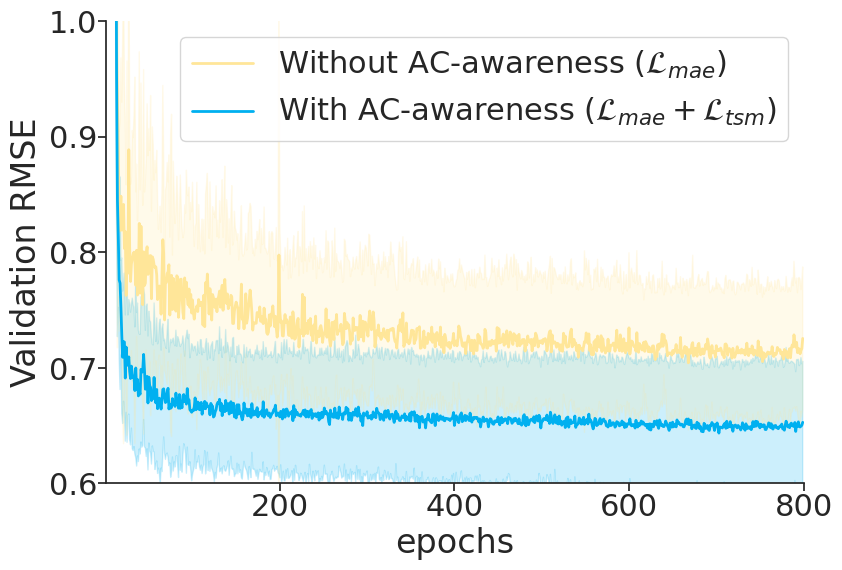

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

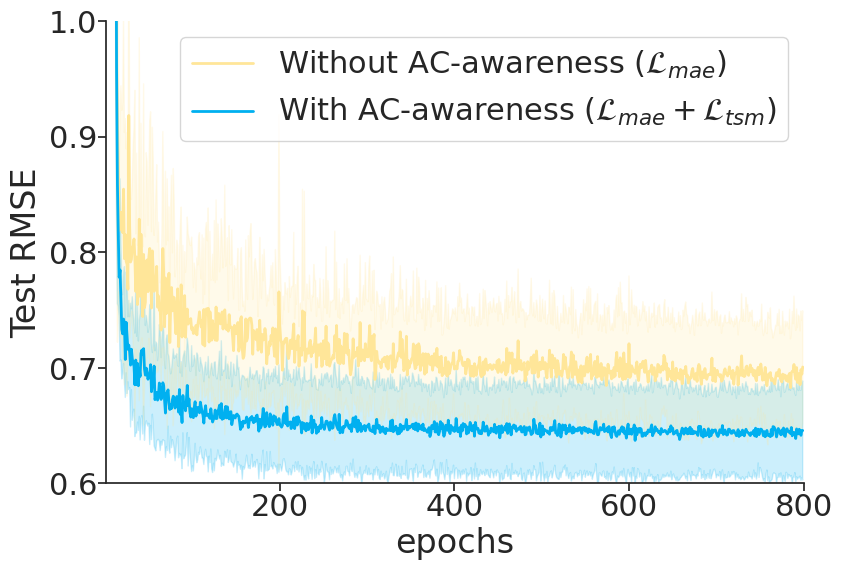

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

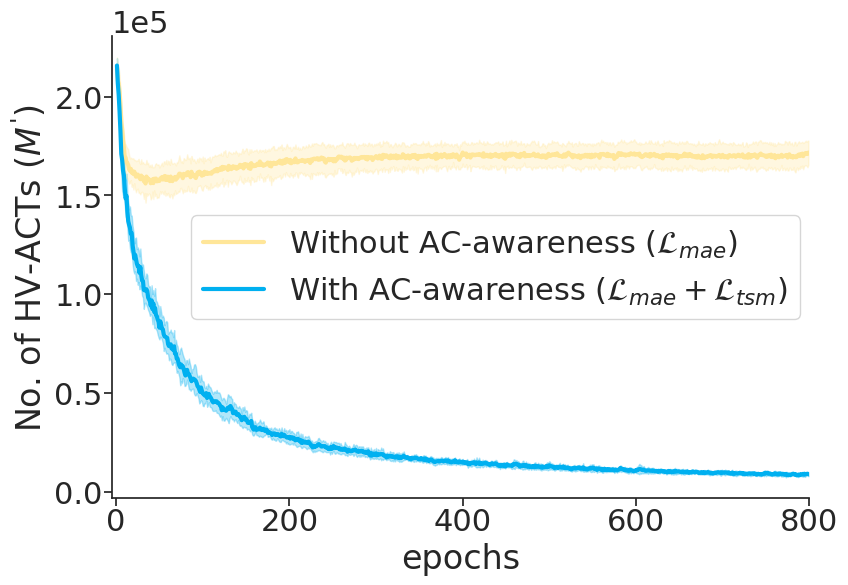

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

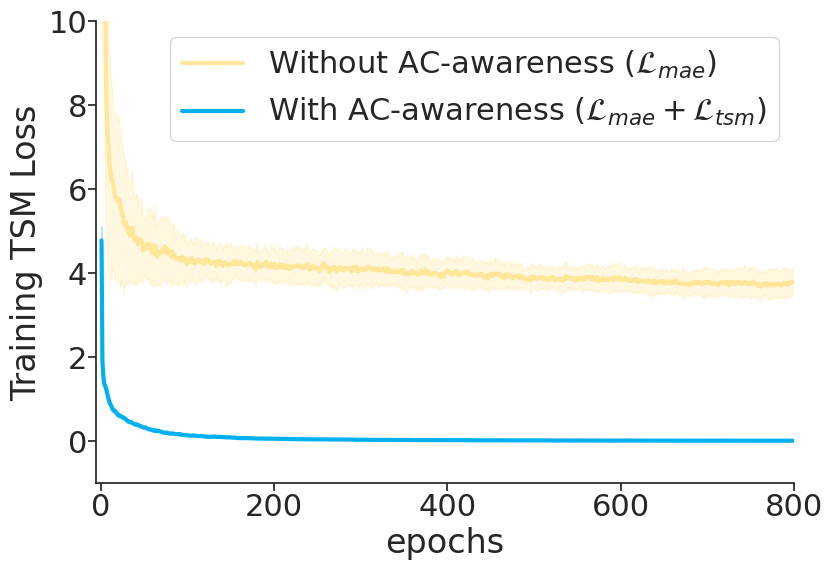

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

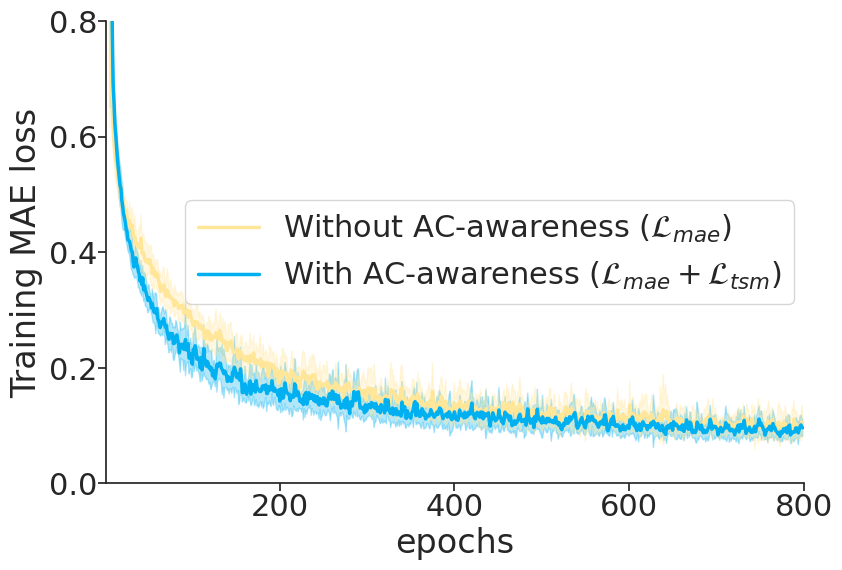

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 